# Predicting Eye Movements 

In [1]:
# Load the necessary packages
library(zoo)
library(keras)
library(tensorflow)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## 1. Load Data and Exploration
Data yang digunakan adalah data pergerakan mata dari package `crqa`

In [2]:
data("crqa", package = "crqa")

In [3]:
# datanya
typeof(RDts1)

[1] "list"

In [4]:
# jumlah data
nrow(RDts1)

[1] 2000

In [5]:
head(RDts1)
tail(RDts1)

,V1
,<int>
1,10
2,2
3,2
4,10
5,10
6,10


,V1
,<int>
1995,1
1996,1
1997,1
1998,1
1999,1
2000,1


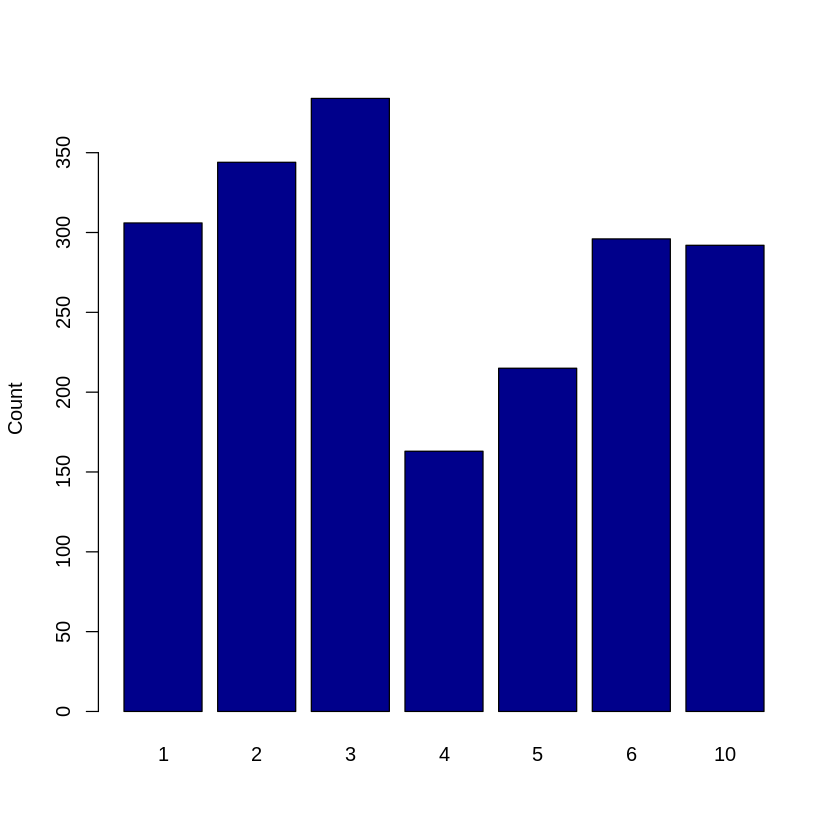

In [6]:
barplot(table(RDts1), ylab="Count", col="darkblue")

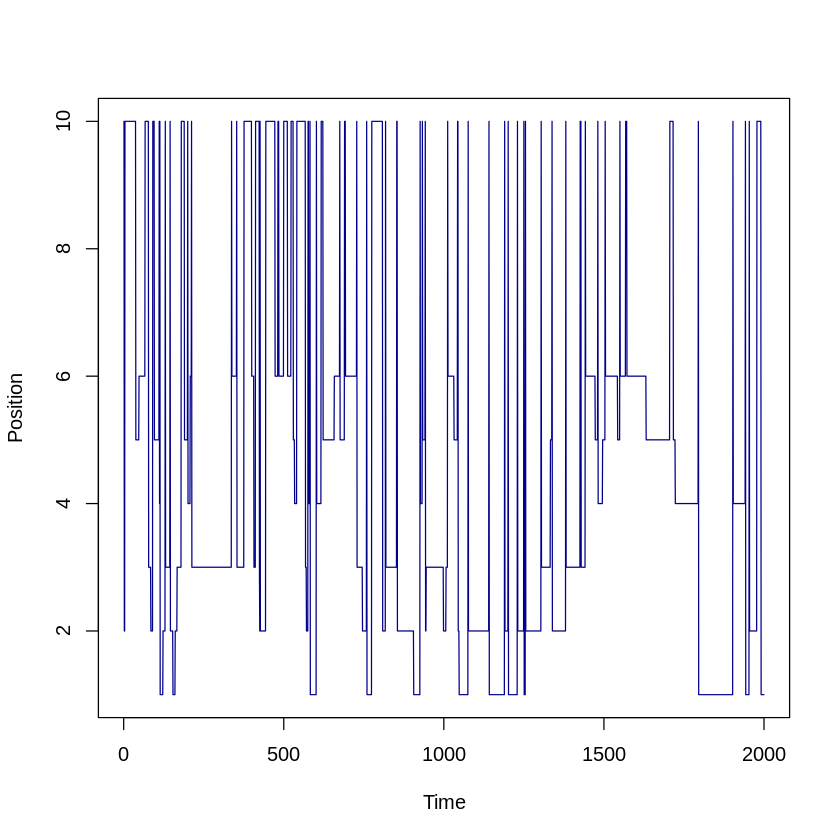

In [7]:
plot(as.ts(RDts1), col="darkblue", ylab="Position")

In [8]:
head(as.ts(RDts1))

[1] 10  2  2 10 10 10

## 2. Data Preparation

In [9]:
# change matrix to timeseries
data <- as.ts(RDts1)

head(data)

[1] 10  2  2 10 10 10

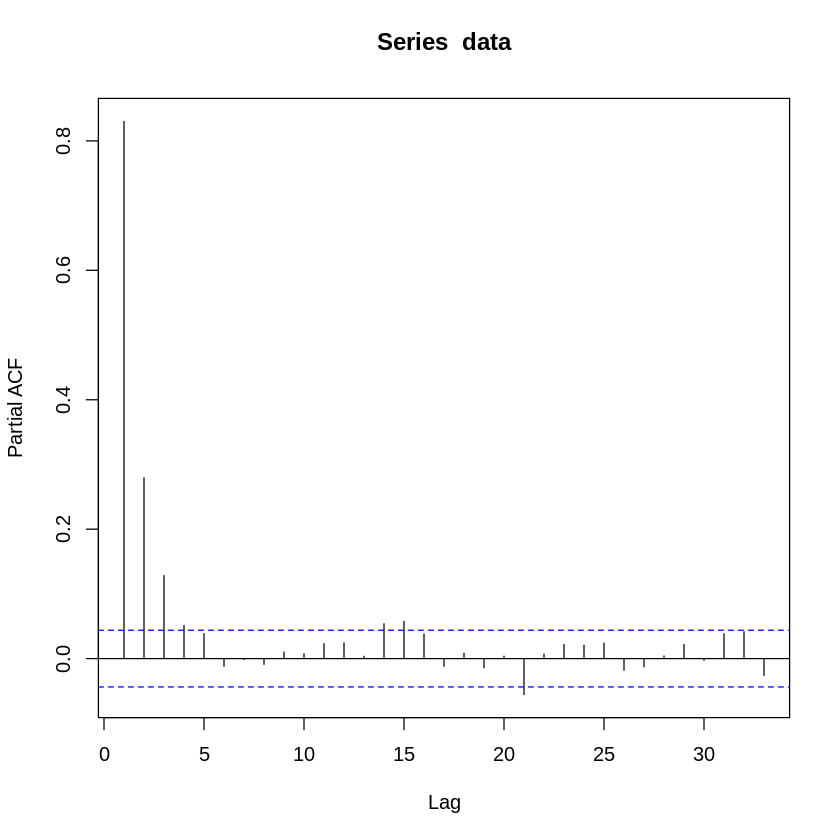

In [10]:
pacf(data)

### 2.1 Lagged

In [11]:
# lagged transform

# define function
lag_transform <- function(data, seq_len){
    for(i in 1:seq_len) {
        lagged <- c(rep(NA, i), data[1:(length(data)-i)])
        if(i == 1){
            DF <- as.data.frame(cbind(lagged, data))
        } else {
            DF <- as.data.frame(cbind(lagged, DF))
        }
    }
    return(DF)
}

# define parameter
seq_len = 1

supervised_data <- lag_transform(data, seq_len)
head(supervised_data, 10)

,lagged,data
,<int>,<int>
1,NA,10
2,10,2
3,2,2
4,2,10
5,10,10
6,10,10
7,10,10
8,10,10
9,10,10


In [12]:
# remove NA value
supervised_data <- supervised_data[-(1:seq_len), ]

head(supervised_data, 10)

,lagged,data
,<int>,<int>
2,10,2
3,2,2
4,2,10
5,10,10
6,10,10
7,10,10
8,10,10
9,10,10
10,10,10


### 2.2 Split Data into Train and Test
Dengan perbandingan train dan test 0.7 0.3

In [13]:
## split into train and test sets

total_data <- nrow(supervised_data)
jumlah_train_set <- round(total_data * 0.7, digits = 0)

train <- supervised_data[1:jumlah_train_set, ]
test  <- supervised_data[(jumlah_train_set+1):total_data,  ]

cat("Train set:", nrow(train), "\n")
cat("Test set:", nrow(test))

Train set: 1399 
Test set: 600

### 2.3 Normalisasi Data

In [14]:
# normalize data

# define function
scale_data <- function(train, test, feature_range = c(0, 1)) {
  x <- train
  fr_min <- feature_range[1]
  fr_max <- feature_range[2]
  std_train <- ((x - min(x) ) / (max(x) - min(x)  ))
  std_test  <- ((test - min(x) ) / (max(x) - min(x)  ))
  
  scaled_train <- std_train *(fr_max -fr_min) + fr_min
  scaled_test <- std_test *(fr_max -fr_min) + fr_min
  
  return( list(scaled_train = as.vector(scaled_train), scaled_test = as.vector(scaled_test) ,scaler= c(min =min(x), max = max(x))) )
  
}


Scaled = scale_data(train, test, c(-1, 1))

In [15]:
## function to inverse-transform
invert_scaling <- function(scaled, scaler, feature_range = c(0, 1)){
  min = scaler[1]
  max = scaler[2]
  t = length(scaled)
  mins = feature_range[1]
  maxs = feature_range[2]
  inverted_dfs = numeric(t)
  
  for( i in 1:t){
    X = (scaled[i]- mins)/(maxs - mins)
    rawValues = X *(max - min) + min
    inverted_dfs[i] <- rawValues
  }
  return(inverted_dfs)
}

### 2.4 Split Data into Input and Output

In [16]:
# split into input and output
# x_train = Scaled$scaled_train[, 1:seq_len]
# y_train = Scaled$scaled_train[, (seq_len+1)]

# x_test = Scaled$scaled_test[, 1:seq_len]
# y_test = Scaled$scaled_test[, (seq_len+1)]

x_train = Scaled$scaled_train[, 1]
y_train = Scaled$scaled_train[, 2]

x_test = Scaled$scaled_test[, 1]
y_test = Scaled$scaled_test[, 2]

## 3. Modeling
### 3.1 Define Model

In [17]:
# define parameter
batch_size = 1                # must be a common factor of both the train and test samples
units = 1                     # can adjust this, in model tuninig phase
nb_epoch = 100   

In [18]:
# Reshape the input to 3-dim
dim(x_train) <- c(length(x_train), 1, 1)

# specify required arguments
X_shape2 = dim(x_train)[2]
X_shape3 = dim(x_train)[3]

In [19]:
# define model
model <- keras_model_sequential() 

model%>%
    layer_lstm(units, batch_input_shape = c(batch_size, X_shape2, X_shape3), stateful= TRUE)%>%
    layer_dense(units = 1)

In [20]:
model %>% compile(
  loss = 'mean_squared_error',
  optimizer = optimizer_sgd( lr= 0.01),  
  metrics = c('mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error')
)

In [21]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm (LSTM)                         (1, 1)                          12          
________________________________________________________________________________
dense (Dense)                       (1, 1)                          2           
Total params: 14
Trainable params: 14
Non-trainable params: 0
________________________________________________________________________________


### 2.2 Fit Model

In [22]:
# Fit the model
history <- model %>% fit(
 x = x_train,
 y = y_train,
 epochs = nb_epoch,
 batch_size = batch_size,
 validation_split = 0.2,
 verbose = 1
)

`geom_smooth()` using formula 'y ~ x'



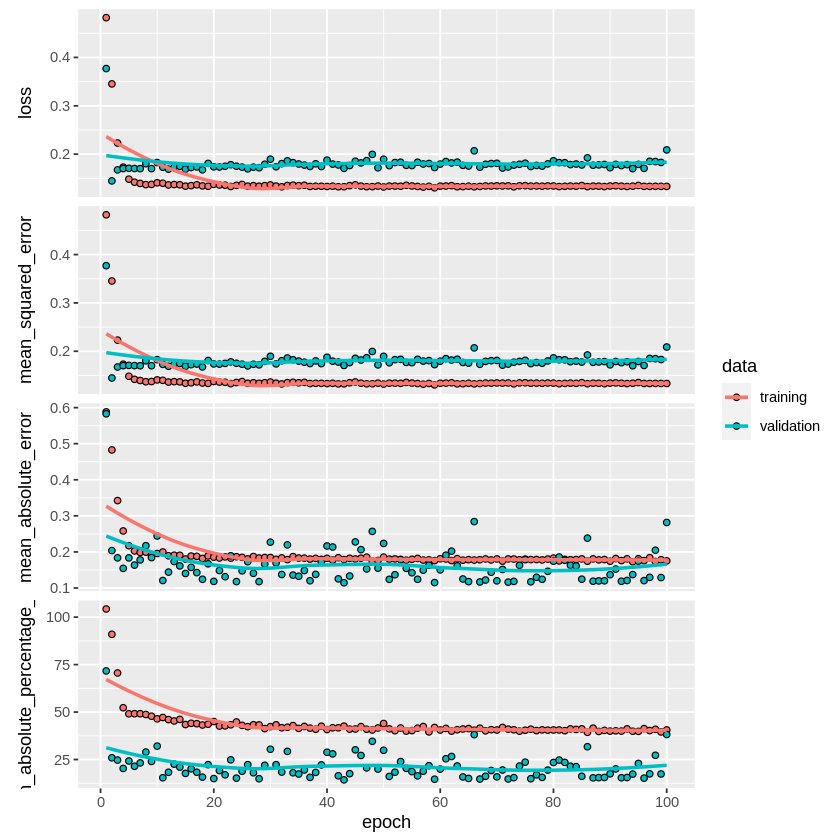

In [23]:
plot(history)

### 2.2 Evaluate Train

In [24]:
(score_train <- model %>% evaluate(x_train, y_train, batch_size=batch_size, verbose=0))

$loss
[1] 0.1639014

$mean_squared_error
[1] 0.1639011

$mean_absolute_error
[1] 0.259982

$mean_absolute_percentage_error
[1] 73.55369

In [25]:
mse_train <- score_train$mean_squared_error
rmse_train <- sqrt(score_train$mean_squared_error)
mae_train <- score_train$mean_absolute_error
mape_train <- score_train$mean_absolute_percentage_error

cat("MSE Train: ", mse_train, "\n")
cat("RMSE Train:", rmse_train, "\n")
cat("MAE Train:", mae_train, "\n")
cat("MAPE Train:", mape_train, "\n")

MSE Train:  0.1639011 
RMSE Train: 0.404847 
MAE Train: 0.259982 
MAPE Train: 73.55369 


In [26]:
# make prediction train

L = length(x_train)
scaler = Scaled$scaler
predictions_train = numeric(L)

for(i in 1:L){
    X <- x_train[i]
    dim(X) <- c(1,1,1)
    X <- tf$cast(X, tf$float32)
    yhat <- model %>% predict(X, batch_size=batch_size)
    # invert scaling
    yhat = invert_scaling(yhat, scaler,  c(-1, 1))
    # store
    predictions_train[i] <- yhat
}

In [27]:
unscaled_y_train = numeric(L)

for(i in 1:L){
    Y <- y_train[i]
    # invert scaling
    yhat = invert_scaling(Y, scaler,  c(-1, 1))
    unscaled_y_train[i] <- yhat
}

In [28]:
korelasi_train <- cor(unscaled_y_train, predictions_train)
r_sq_train <- korelasi_train^2

cat("Korelasi Train: ", korelasi_train, "\n")
cat("R-square Train: ", r_sq_train, "\n")

Korelasi Train:  0.8336987 
R-square Train:  0.6950535 


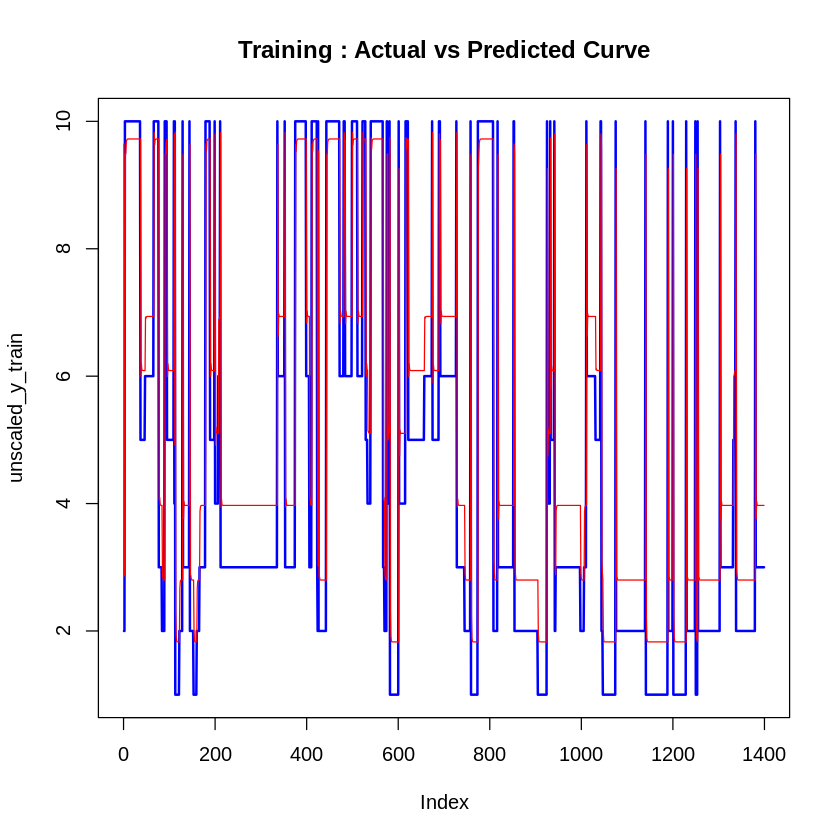

In [37]:
plot(unscaled_y_train, col="blue", type="l",main ="Training : Actual vs Predicted Curve", lwd = 2) 
lines(predictions_train, type = "l", col = "red", lwd = 1)

### 2.2 Evaluate Test

In [30]:
# make prediction

L = length(x_test)
scaler = Scaled$scaler
predictions_test = numeric(L)

for(i in 1:L){
    X <- x_test[i]
    dim(X) <- c(1,1,1)
    X <- tf$cast(X, tf$float32)
    yhat <- model %>% predict(X, batch_size=batch_size)
    # invert scaling
    yhat = invert_scaling(yhat, scaler,  c(-1, 1))
    # store
    predictions_test[i] <- yhat
}

In [31]:
unscaled_y_test = numeric(L)

for(i in 1:L){
    Y <- y_test[i]
    # invert scaling
    yhat = invert_scaling(Y, scaler,  c(-1, 1))
    unscaled_y_test[i] <- yhat
}

In [39]:
korelasi_test <- cor(unscaled_y_test, predictions_test)
r_sq_test <- korelasi_test^2

cat("Korelasi Test: ", korelasi_test, "\n")
cat("R-square Test: ", r_sq_test, "\n")

Korelasi Test:  0.8569178 
R-square Test:  0.7343081 


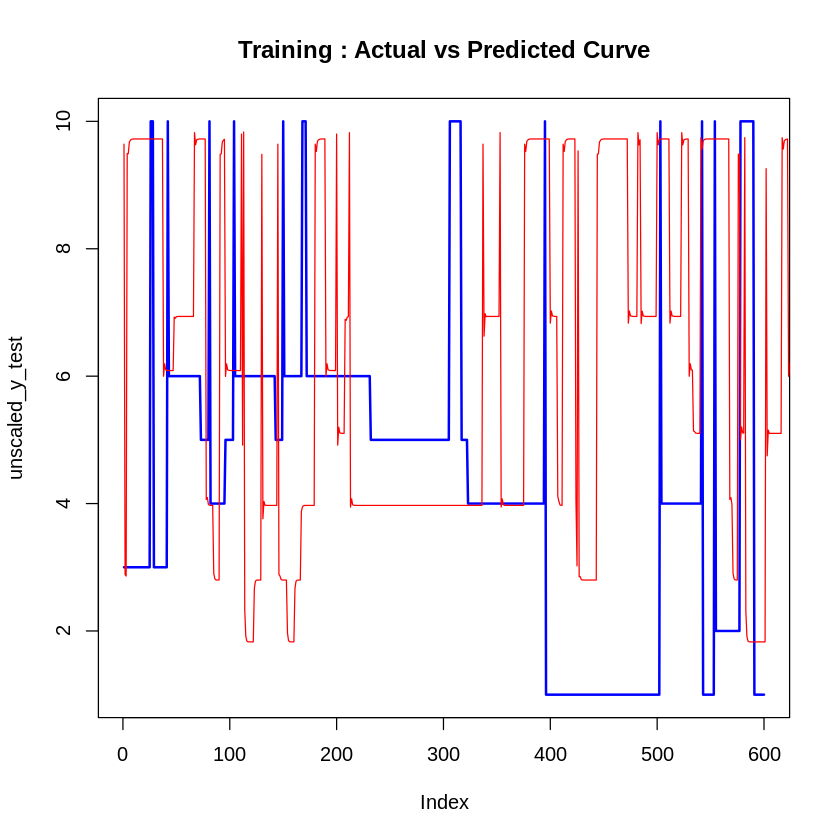

In [38]:
plot(unscaled_y_test, col="blue", type="l",main ="Training : Actual vs Predicted Curve", lwd = 2) 
lines(predictions_train, type = "l", col = "red", lwd = 1)

In [34]:
# Reshape the input to 3-dim
dim(x_test) <- c(length(x_test), 1, 1)

In [35]:
(score_train <- model %>% evaluate(x_test, y_test, batch_size=batch_size, verbose=0))

$loss
[1] 0.1140274

$mean_squared_error
[1] 0.114027

$mean_absolute_error
[1] 0.2524687

$mean_absolute_percentage_error
[1] 115.767

In [36]:
mse_test <- score_train$mean_squared_error
rmse_test <- sqrt(score_train$mean_squared_error)
mae_test <- score_train$mean_absolute_error
mape_test <- score_train$mean_absolute_percentage_error

cat("MSE Test: ", mse_test, "\n")
cat("RMSE Test:", rmse_test, "\n")
cat("MAE Test:", mae_test, "\n")
cat("MAPE Test:", mape_test, "\n")

MSE Test:  0.114027 
RMSE Test: 0.3376789 
MAE Test: 0.2524687 
MAPE Test: 115.767 


## References

* http://rwanjohi.rbind.io/2018/04/05/time-series-forecasting-using-lstm-in-r/